Student 1 :
- Mohamed-Amine BOUSAHIH
- 71500267
- M2 MIDS

Student 2 :
- Duc Nguyen DUONG 
- 71604573
- M2 MIDS

# Homework 1

# A fashionable use case : clothing classification with `fashion-mnist`

- Load data with `fashion_mnist.load_data()` 
- There is no validation set, only a train and test set. 
- The labels correspond to the following things

| Label number | Label name  |
|--------------|-------------|
| 0	           | T-shirt/top |
| 1	           | Trouser     |
| 2	           | Pullover    |
| 3	           | Dress       |
| 4	           | Coat        |
| 5	           | Sandal      |
| 6	           | Shirt       |
| 7	           | Sneaker     |
| 8	           | Bag         |
| 9	           | Ankle boot  |

## Your job

- Try to understand the data, visualize it, like we did before with MNIST and noMNIST
- Create a neural network, using the ideas from before, that classify accurately the clothes on the test set
- You will need to build a validation set from the train set in order to tune hyperparameters

## We want to see the following things

- Some learning curves (training) and the accuracy obtained on the test set for the architecture you considered
- A discussion about the impact of the hyperparameters on the accuracy (size of the kernels, number of kernels, number of layers, etc.) 
- A clear comparison between your solutions (a table, or plots comparing the results obtained with different hyper-parameters and different architectures)
- An explanation of what kind of clothes are hard to distinguish and why (some visual explanation)
- You'll get a good grade if you reach a good accuracy **and** if your notebook is clean, with clear graphs and explanations of what you did **and** if you did serious comparisons between different architectures
- You can do everything on your laptop, but it might be a good idea to use google `colab` (https://colab.research.google.com/) to get free access to a GPU
- You will send your notebook **containing** the results (**WE WON'T RUN YOUR NOTEBOOK**), namely with the graphs and results that you want to show, as a **unique** jupyter notebook file (`.ipynb` extension). We won't open any other supplementary file.

## Send your work using the following google form :

- https://forms.gle/G3Rwfcuj3MZfgXhr8

(you will need to create a google account if you don't have one).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import os

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import losses, optimizers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from keras import regularizers, optimizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Fashion - MNIST : Exploring and Visualizing the dataset.

We import the train data and the test data from keras dataset


In [ ]:
import tensorflow
from tensorflow.keras.datasets import fashion_mnist

#number of classes
num_classes = 10

#input image dimension
img_rows, img_cols = 28,28

#load the dataset and labels
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

print('train_images shape:', train_images.shape)
print('test_images shape:', test_images.shape)
print('train_labels shape:', train_labels.shape)
print('test_labels shape:', test_labels.shape)

print(train_images.shape[0], 'train samples')
print(test_images.shape[0], 'test samples')

4423680/4422102 [==============================] - 0s 0us/step
train_images shape: (60000, 28, 28)
test_images shape: (10000, 28, 28)
train_labels shape: (60000,)
test_labels shape: (10000,)
60000 train samples
10000 test samples


* Fashion-MNIST is a dataset of clothes images—consisting of a training set of 60,000 examples and a test set of 10,000 examples.
* Each example is a 28x28 grayscale image, 
associated with a label from 10 classes.

We try to visualize the distribution of classes in the training dataset and the testing dataset

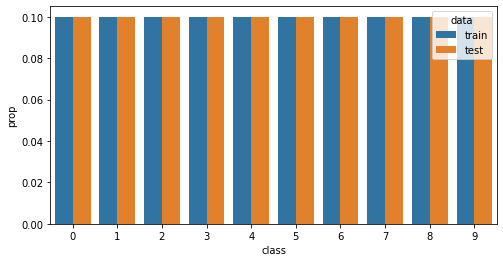

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

labels_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_labels) / train_labels.shape[0], 
                         np.bincount(test_labels) / test_labels.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=labels_counts, ax=ax)

As we can see, the data is perfectly balanced in the training data and also in the testing data. Each class hold 10% the data. So, there is no over sampling or under sampling.

We create a Python dict for later visualization


In [ ]:
label_dict = {
    0 : "T-shirt/top",
    1 : "Trouser",
    2 : "Pullover",
    3 : "Dress",
    4 : "Coat",
    5 : "Sandal",
    6 : "Shirt",
    7 : "Sneaker",
    8 : "Bag",
    9 : "Ankle boot"
}

Now let see 30 first items in the training data with the associated labels

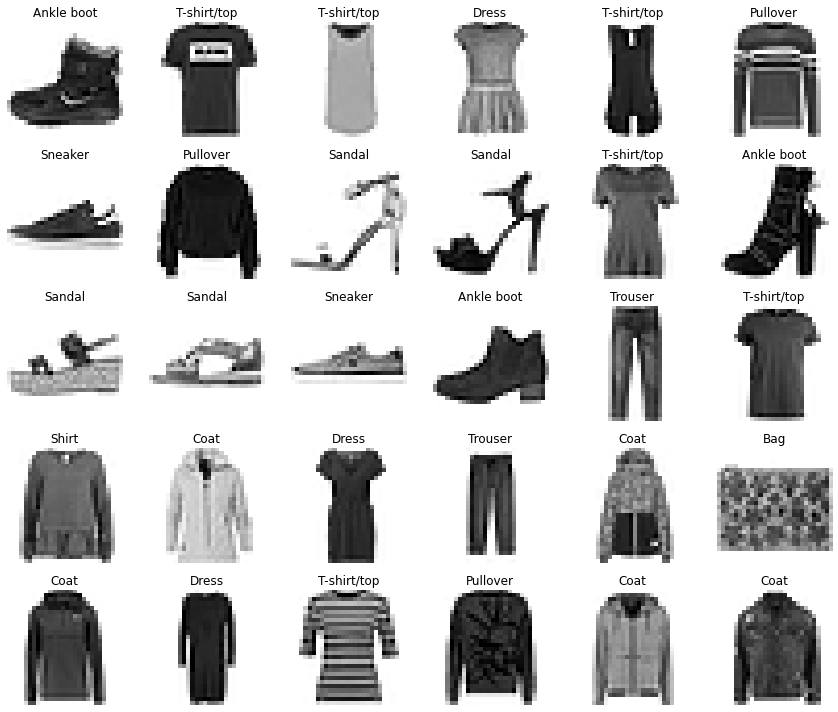

In [ ]:
n_rows = 5
n_cols = 6
plt.figure(figsize=(12, 10))
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.set_title(label_dict[train_labels[i]])
    plt.imshow(train_images[i],interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()



Look at these Images, I bet, there will be images which even the humans won't be able to classify.

Since we are going to train the neural network using Gradient Descent, we must scale the input features. For simplicity, we'll scale pixel intensities down to the 0-1 range by dividing them by 255.0 (max) (this also converts them to floats).

We also need to reshape the data (add fourth dimensions, i.e changing from (60000,28,28) to (60000,28,28,1)).

In [ ]:
train_images /= train_images.max()
test_images /= test_images.max()
print(train_images.min(axis=None), test_images.max(axis=None))

0.0 1.0


In [ ]:
if K.image_data_format() == 'channels_first':
    train_images = train_images.reshape(train_images.shape[0], 1, img_rows, img_cols)
    test_images = test_images.reshape(test_images.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    train_images = train_images.reshape(train_images.shape[0], img_rows, img_cols, 1)
    test_images = test_images.reshape(test_images.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

We also need to transform all the labels to one-hot vectors

In [ ]:
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
train_labels[:10]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]], dtype=float32)

We note that the dataset is already split into a training set and a test set, but there is no validation set, so we'll create one now by shuffling 5 times train data and then take 50000 first data as training sample and 10000 last data as validation sample.

In [ ]:
indexes = np.arange(train_images.shape[0])
for _ in range(5): indexes = np.random.permutation(indexes)  # shuffle 5 times!
train_images = train_images[indexes]
train_labels = train_labels[indexes]

# 'split' into cross-val & train sets (use 10000 records in cross-val set)
val_count = 10000
valid_images = train_images[:val_count]
valid_labels = train_labels[:val_count]
train_images = train_images[val_count:]
train_labels = train_labels[val_count:]

In [ ]:
print(valid_images.shape,train_images.shape)

(10000, 28, 28, 1) (50000, 28, 28, 1)


In [ ]:
input_shape = train_images[0].shape
input_shape

(28, 28, 1)

Plotting functions for training and validation curves

In [ ]:
def plot_history_acc(history, title=''):
    plt.figure(figsize=(7, 5))
    plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
    plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Valid')
    plt.legend(fontsize=14)
    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)
    plt.tight_layout()

In [ ]:
def plot_history_loss(history, title=''):
    plt.figure(figsize=(7, 5))
    plt.plot(history.epoch, history.history['loss'], lw=3, label='Training')
    plt.plot(history.epoch, history.history['val_loss'], lw=3, label='Valid')
    plt.legend(fontsize=14)
    plt.title(title, fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.tight_layout()


## Example of architecture - Gaiffas&Fisher's Architecture, not bad ... but improvable ! 

As a start, we can use the following architecture proposed by teachers(but we can and will change it) :

- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 128 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Convolutional layer with 256 filters and 3 * 3 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25

- Dense layer with 256 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

In [ ]:
model_teacher = Sequential()
model_teacher.add(Conv2D(64, kernel_size=(5, 5), activation='relu', input_shape=input_shape, name='conv2d_1'))
model_teacher.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_1'))
model_teacher.add(Dropout(0.25, name='dropout_1'))
model_teacher.add(Conv2D(128, kernel_size=(5, 5), activation='relu', input_shape=input_shape, name='conv2d_2'))
model_teacher.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_2'))
model_teacher.add(Dropout(0.25, name='dropout_2'))
model_teacher.add(Conv2D(256, kernel_size=(3, 3), activation='relu', input_shape=input_shape, name='conv2d_3'))
model_teacher.add(MaxPooling2D(pool_size=(2, 2), name='max_pool_3'))
model_teacher.add(Dropout(0.25, name='dropout_3'))
model_teacher.add(Flatten(name='flatten'))
model_teacher.add(Dense(256, activation='relu', name='dense'))
model_teacher.add(Dropout(0.5, name='dropout_4'))
model_teacher.add(Dense(num_classes, activation='softmax', name='output'))
                    
model_teacher.compile(loss=losses.categorical_crossentropy,
                  optimizer="adam",
                  metrics=['accuracy'])

model_teacher.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pool_1 (MaxPooling2D)    (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
max_pool_2 (MaxPooling2D)    (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 256)        

In [ ]:
def fit_model(model,batch_size,epochs,patience,save_point):
      with tf.device('/device:GPU:0'):
        es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=patience)
        mc = ModelCheckpoint(save_point, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
        batch_size = batch_size

        # number of steps
        epochs = epochs

        # Run the train
        history = model.fit(
            train_images, train_labels,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(valid_images, valid_labels),
            callbacks=[es, mc]
        )

        score = model.evaluate(test_images, test_labels, verbose=0)
        print('Test loss:', score[0])
        print('Test accuracy:', score[1])
        return history

In [ ]:
def evaluate_model(model_path):
      with tf.device('/device:GPU:0'):
        saved_model = load_model(model_path)
        _, train_acc = saved_model.evaluate(train_images, train_labels, verbose=0)
        _, test_acc = saved_model.evaluate(test_images, test_labels, verbose=0)
        print('Train_accuracy: %.3f, Test_accuracy: %.3f' % (train_acc, test_acc))

In [ ]:
history_teacher = fit_model(model_teacher,128,50,50,'drive/My Drive/Colab Notebooks/dm2_models/teacher_model.h5')

Epoch 1/50
389/391 [============================>.] - ETA: 0s - loss: 0.7350 - accuracy: 0.7259
Epoch 00001: val_accuracy improved from -inf to 0.84010, saving model to drive/My Drive/Colab Notebooks/dm2_models/teacher_model.h5
391/391 [==============================] - 7s 18ms/step - loss: 0.7341 - accuracy: 0.7262 - val_loss: 0.4332 - val_accuracy: 0.8401
Epoch 2/50
391/391 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8471
Epoch 00002: val_accuracy improved from 0.84010 to 0.87410, saving model to drive/My Drive/Colab Notebooks/dm2_models/teacher_model.h5
391/391 [==============================] - 6s 16ms/step - loss: 0.4319 - accuracy: 0.8471 - val_loss: 0.3372 - val_accuracy: 0.8741
Epoch 3/50
388/391 [============================>.] - ETA: 0s - loss: 0.3655 - accuracy: 0.8681
Epoch 00003: val_accuracy improved from 0.87410 to 0.88270, saving model to drive/My Drive/Colab Notebooks/dm2_models/teacher_model.h5
391/391 [==============================] - 7s 

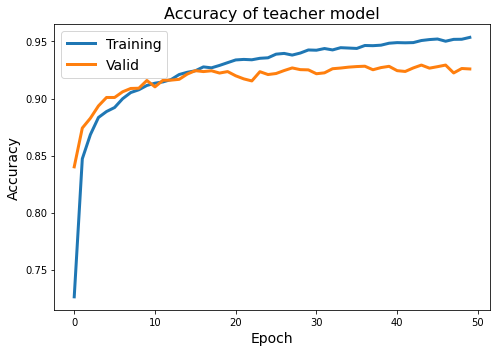

In [ ]:
plot_history_acc(history_teacher, title='Accuracy of teacher model')

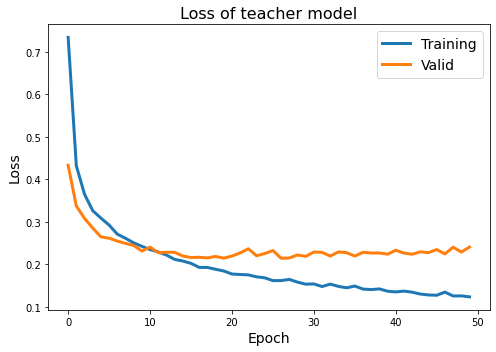

In [ ]:
plot_history_loss(history_teacher, title='Loss of teacher model')

In [ ]:
evaluate_model('drive/My Drive/Colab Notebooks/dm2_models/teacher_model.h5')

Train_accuracy: 0.980, Test_accuracy: 0.921


Remark 1 : This CNN of our teacher reaches over 92% accuracy on test accuracy (on validation set). It's pretty good !
But we can see an overfitting since the 13th or 14th epoch.

Remark 2 : A way to regularize the previous CNN is to stop training as soon as the loss value reaches a minimum or the accuracy score reaches a maximum on validation test. This is called Early Stopping.
As the epochs go by the algorithm learns, and its accuracy on the training set goes up, along with is validation accurancy on the validation set.

Remark 3 : A common mistake is to use convolution kernels that are too large. For example, instead of using a convolutional layer with a 5x5 kernel, stack two layers with 3x3 kernels : it will use fewer parameters and require fewer computations, and it will usually perform better. 

Remark 4 : We using He (he_normal) initialiation with relu activation that can significantly reduce the dander of the vanishing/exploding gradients problems at the beginning of training. But it doesn't guarantee that they won't come back during training. More later ! 


## Our 1st model ! BousahihDuong-Net01 👨‍🔬

Let's go through this model :
- We try to use the teacher structure skeleton and add more layers.

- The first layer uses 64 fairly small filter (3x3) but no stride because the input images are not very large. It also set input_shape=[28,28,1], because the images are 28x28 pixels, with a single color channel (i.e grayscale). We also have a kernel_initializer 'he_normal' and relu activation.
- Next we have again a layer uses 64 small filter(3x3) with relu activation.
- Then we have a max pooling layer which uses a pool size of 2, so it divides each spatial dimension by a factor 2 and a dropout with p=0.25.

- Then we repeat the same structure twice : two convolutional layers followed by a max pooling layer. For larger images, we could repeat this structure several more times(the number of repetititons is a hyperparameters that we can tune).

Remark : Note that the number of filters grows as we climb up the CNN toward the output layer(it is initially 64, then 128, then 256) : it makes sense for it to grow, since the number of low-level features is often fairly low (for example small circles, horizontal lines), but there are many different ways to combine them into higher-level features. It is a common practice to double the number of filters after each pooling layer: since a pooling layer divides each spatial dimension by a factor of 2, we can afford to double the number of feature maps in the next layer without fear of exploding the number of parameters, memory usage, or computational load.

- We repeat the same strucuture. 
- Next is the fully connected network, composed of two hidden dense layers and a dense output layer. Note that we must flatten its inputs, since a dense network expects a 1D array of features for each instance. We also add two dropout layers (with a dropout rate of 30% and an another of 20%) to reduce overfitting

Remark : We chose the Adam optimizer because we saw in class that adaptive optimization methods (including RMSProp, Adam ..) are often great, converging fast to a good solution. 

In [ ]:
def build_model_1():
    model = Sequential([
            Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
                   input_shape=input_shape,kernel_initializer='he_normal'),
            Conv2D(64, kernel_size=(3, 3), activation='relu'),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),

            Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
            Conv2D(128, kernel_size=(3, 3), activation='relu'),        
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),        

            Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
            Conv2D(256, kernel_size=(3, 3), activation='relu'),    
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.50),        

            Flatten(),

            Dense(1024, activation='relu'),
            Dropout(0.30),

            Dense(512, activation='relu'),
            Dropout(0.20),

            Dense(num_classes, activation='softmax')
        ])
    model.compile(optimizer="adam",
                    loss = losses.categorical_crossentropy,
                    metrics=['accuracy'])
    return model

In [ ]:
model_1 = build_model_1()
model_1.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 13, 13, 128)       73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 11, 11, 128)       147584    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 128)        

Here, we will use an early stop with a patience of 10 epochs, i.e, we will wait 10 epochs since the last improvement of our model.

In [ ]:
history_1 = fit_model(model_1,64,50,10,'drive/My Drive/Colab Notebooks/dm2_models/best_model_1.h5')

Epoch 1/50
781/782 [============================>.] - ETA: 0s - loss: 0.6393 - accuracy: 0.7647
Epoch 00001: val_accuracy improved from -inf to 0.85890, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_1.h5
782/782 [==============================] - 22s 28ms/step - loss: 0.6392 - accuracy: 0.7647 - val_loss: 0.3704 - val_accuracy: 0.8589
Epoch 2/50
780/782 [============================>.] - ETA: 0s - loss: 0.3822 - accuracy: 0.8629
Epoch 00002: val_accuracy improved from 0.85890 to 0.88070, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_1.h5
782/782 [==============================] - 21s 27ms/step - loss: 0.3823 - accuracy: 0.8629 - val_loss: 0.3188 - val_accuracy: 0.8807
Epoch 3/50
782/782 [==============================] - ETA: 0s - loss: 0.3210 - accuracy: 0.8851
Epoch 00003: val_accuracy improved from 0.88070 to 0.90640, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_1.h5
782/782 [==============================] - 22s 

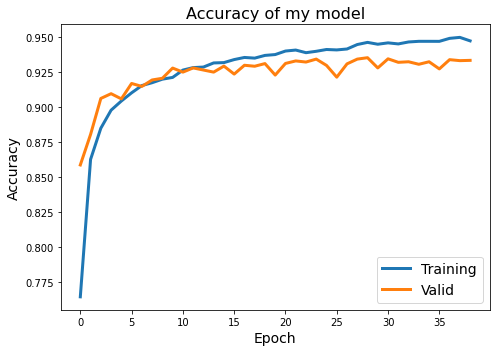

In [ ]:
plot_history_acc(history_1, title='Accuracy of my model')

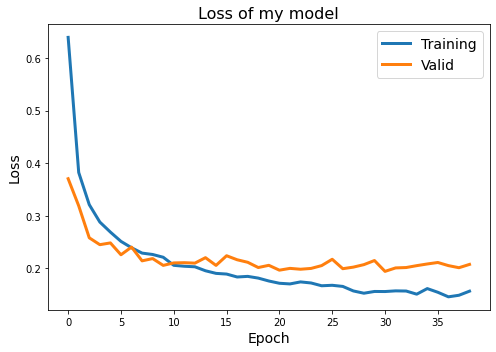

In [ ]:
plot_history_loss(history_1, title='Loss of my model')

In [ ]:
evaluate_model('drive/My Drive/Colab Notebooks/dm2_models/best_model_1.h5')

Train_accuracy: 0.971, Test_accuracy: 0.930


Remark : We are seeing a decrease of overfitting of our 1st model. Nevertheless, we can still reduce this overfitting and the gap between val_accuracy and test_accuracy.

Remark : As we have seen He initialization doesn't guarantee that the danger of the vanishing/exploding gradients problems won't come back during traning. 


## Our 2nd model ! BousahihDuong-Net02 👨‍🔬

- We add a Batch Normalization after every Conv2D layer where we achieve zero mean and variance one. It scales down outliers and forces the network to learn features in a distributed way, not relying too much on a particular weight and makes the model better generalize the images.


In [ ]:
def build_model_2():
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',
               input_shape=input_shape,kernel_initializer='he_normal'),
        BatchNormalization(),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),        
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(256, kernel_size=(3, 3), activation='relu'),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.50),        
        
        Flatten(),
        
        Dense(1024, activation='relu'),
        Dropout(0.30),
        
        Dense(512, activation='relu'),
        Dropout(0.20),
        
        Dense(num_classes, activation='softmax')
    ])
    
    adam = optimizers.Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss = losses.categorical_crossentropy,
                  metrics=['accuracy'])
    return model

In [ ]:
model_2 = build_model_2()
model_2.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 13, 13, 128)      

In [ ]:
history_2 = fit_model(model_2,64,50,10,'drive/My Drive/Colab Notebooks/dm2_models/best_model_2.h5')

Epoch 1/50
781/782 [============================>.] - ETA: 0s - loss: 0.8068 - accuracy: 0.7080
Epoch 00001: val_accuracy improved from -inf to 0.81570, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_2.h5
782/782 [==============================] - 27s 34ms/step - loss: 0.8071 - accuracy: 0.7080 - val_loss: 0.4869 - val_accuracy: 0.8157
Epoch 2/50
781/782 [============================>.] - ETA: 0s - loss: 0.4712 - accuracy: 0.8290
Epoch 00002: val_accuracy improved from 0.81570 to 0.86760, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_2.h5
782/782 [==============================] - 25s 31ms/step - loss: 0.4711 - accuracy: 0.8291 - val_loss: 0.3624 - val_accuracy: 0.8676
Epoch 3/50
781/782 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8640
Epoch 00003: val_accuracy improved from 0.86760 to 0.88440, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_2.h5
782/782 [==============================] - 25s 

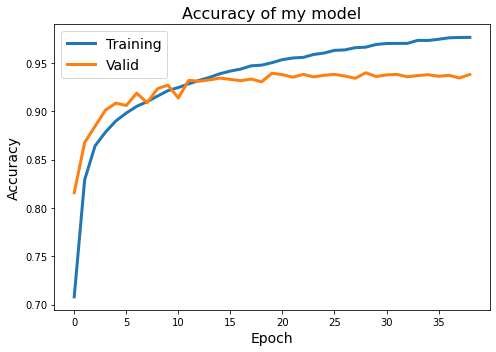

In [ ]:
plot_history_acc(history_2, title='Accuracy of my model')

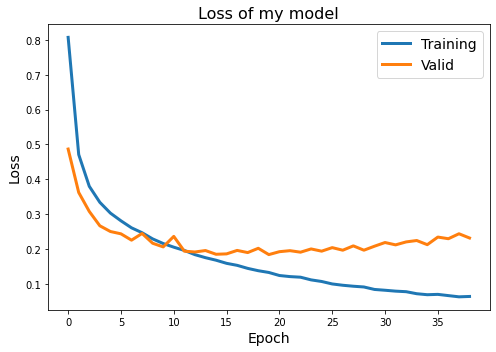

In [ ]:
plot_history_loss(history_2, title='Loss of my model')

In [ ]:
evaluate_model('drive/My Drive/Colab Notebooks/dm2_models/best_model_2.h5')

Train_accuracy: 0.989, Test_accuracy: 0.936


We can see here that the testing accuracy is improved from 0.93 to 0.936, that is nice. But the training accuracy is also higher which is not good because we overfit more our model.

We can see that Batch Normalization considerably improved our model, leading to a huge improvement for our classification task. The vanishing gradients problem was strongly reduced. 

Batch Normalization does, however add some complexity to our model. There is a runtime penalty : the CNN makes slower predictions due to the extra computations requiered at each layer.

Remark : We have a CNN's model with millions of parameters. This gives him an incredible amount of freedom and means that he can fit a huge variety of complex datasets. But this great flexibility also makes our model prone to overfitting the training set. WE NEED REGULARIZATION !!!

Even though Batch Normalization was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer. In our 3rd model, we'll use an other popular regularization technique : l2 regularization (to constrain connection weights).

## Our 3rd model ! BousahihDuong-Net03 👨‍🔬

# Avoiding overfitting through regularization.

"With four parameters I can fit an elephant and with five I can make him wiggle his trunk" - John Von Neumann, Enrico Fermi Nature 427

In [ ]:
def build_model_3(l2_loss_lambda=None):
    l2 = None if l2_loss_lambda is None else regularizers.l2(l2_loss_lambda)
    
    model = Sequential([
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2,
               input_shape=input_shape,kernel_initializer='he_normal'),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),        
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),        
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=l2),
        BatchNormalization(),
        Dropout(0.25),
        Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2),
        BatchNormalization(),    
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.50),        
        
        Flatten(),
        
        Dense(1024, activation='relu', kernel_regularizer=l2),
        Dropout(0.30),
        
        Dense(512, activation='relu', kernel_regularizer=l2),
        Dropout(0.20),
        
        Dense(num_classes, activation='softmax')
    ])
    
    adam = optimizers.Adam(lr=0.0001, decay=1e-6)
    model.compile(optimizer=adam,
                  loss = losses.categorical_crossentropy,
                  metrics=['accuracy'])
    return model

In [ ]:
model_3 = build_model_3(0.0001)
model_3.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization_6 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_20 (Dropout)         (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 26, 26, 64)        36928     
_________________________________________________________________
batch_normalization_7 (Batch (None, 26, 26, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 13, 13, 64)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 13, 13, 64)       

In [ ]:
history_3 = fit_model(model_3,64,50,10,'drive/My Drive/Colab Notebooks/dm2_models/best_model_3.h5')

Epoch 1/50
781/782 [============================>.] - ETA: 0s - loss: 1.1924 - accuracy: 0.6308
Epoch 00001: val_accuracy improved from -inf to 0.73650, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_3.h5
782/782 [==============================] - 29s 37ms/step - loss: 1.1923 - accuracy: 0.6308 - val_loss: 0.8509 - val_accuracy: 0.7365
Epoch 2/50
781/782 [============================>.] - ETA: 0s - loss: 0.7930 - accuracy: 0.7714
Epoch 00002: val_accuracy improved from 0.73650 to 0.81060, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_3.h5
782/782 [==============================] - 27s 34ms/step - loss: 0.7930 - accuracy: 0.7714 - val_loss: 0.6763 - val_accuracy: 0.8106
Epoch 3/50
781/782 [============================>.] - ETA: 0s - loss: 0.6866 - accuracy: 0.8160
Epoch 00003: val_accuracy improved from 0.81060 to 0.84080, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_3.h5
782/782 [==============================] - 27s 

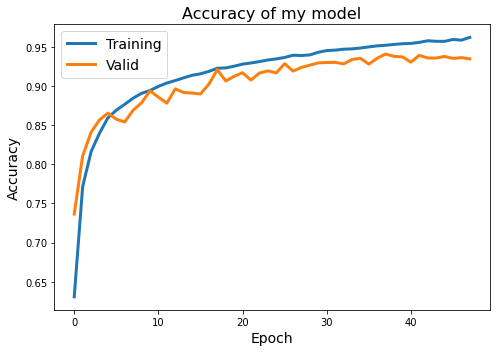

In [ ]:
plot_history_acc(history_3, title='Accuracy of my model')

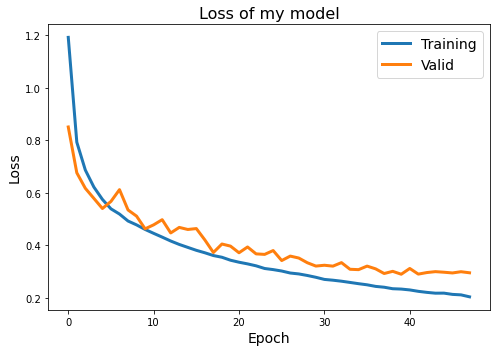

In [ ]:
plot_history_loss(history_3,title='Loss of my model')

In [ ]:
evaluate_model('drive/My Drive/Colab Notebooks/dm2_models/best_model_3.h5')

Train_accuracy: 0.975, Test_accuracy: 0.933


As we can see here, we reduced the gap between the training accuracy and the testing accuracy and still have a good accuracy of 0.933. But the gap is still 4%, it just decreased 1.5% from the model 2. We still want to avoid the overfitting phenomenon. So let's go for the 4th model.

## Our 4th model ! BousahihDuong-Net04👨‍🔬
# Data augmentation



A model with millions of parameters (like our model) would severely risk overfitting the training set, especially if there are not enough training instances.


To reduce overfitting, we can perform data augmentation (a regularization technique) by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions : we can slighty shift, rotate and resize every picture in the training set and add the result to the training set. This force our model to be more tolerant to variations in the position, orientation and size of the objects in the pictures. 

Data augmentation artificially increases the size of the training set by generating many realistic variants of each training instance. 

In [ ]:
#data augmentation
datagen = ImageDataGenerator(
        rotation_range = 8,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        shear_range = 0.3,# shear angle in counter-clockwise direction in degrees  
        width_shift_range=0.08,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.08,  # randomly shift images vertically (fraction of total height)
        vertical_flip=True)  # randomly flip images

In [ ]:
model_4 = build_model_3(0.0001)

In [ ]:
with tf.device('/device:GPU:0'):
    es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
    mc = ModelCheckpoint('drive/My Drive/Colab Notebooks/dm2_models/best_model_4.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
    batch_size = 64

    # number of steps
    epochs = 200

    # Run the train
    history_4 =  model_4.fit_generator(datagen.flow(train_images, train_labels, batch_size = batch_size),
                                       epochs=epochs,
                                       verbose=1,
                                       validation_data=datagen.flow(valid_images, valid_labels, batch_size = batch_size),
                                       callbacks=[es, mc]
      )

score1 = model_4.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/200
782/782 [==============================] - ETA: 0s - loss: 1.4499 - accuracy: 0.5306
Epoch 00001: val_accuracy improved from -inf to 0.66280, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_4.h5
782/782 [==============================] - 35s 45ms/step - loss: 1.4499 - accuracy: 0.5306 - val_loss: 1.0904 - val_accuracy: 0.6628
Epoch 2/200
782/782 [==============================] - ETA: 0s - loss: 1.0195 - accuracy: 0.6828
Epoch 00002: val_accuracy improved from 0.66280 to 0.69700, saving model to drive/My Drive/Colab Notebooks/dm2_models/best_model_4.h5
782/782 [==============================] - 34s 44ms/step - loss: 1.0195 - accuracy: 0.6828 - val_loss: 0.9813 - val_accuracy: 0.6970
Epoch 3/200
781/782 [============================>.] - ETA: 0s - loss: 0.9049 - accuracy: 0.7281
Epoch 00003: val_accuracy improved from 0.69700 to 0.73010, saving model to drive/My Drive/Colab Noteb

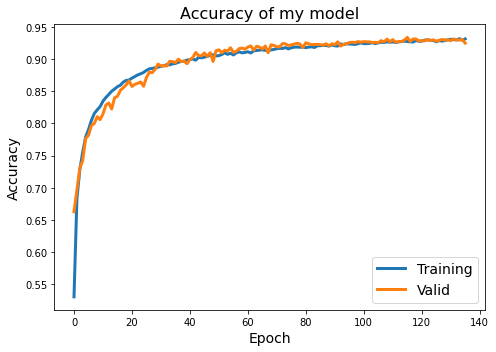

In [ ]:
plot_history_acc(history_4, title='Accuracy of my model')

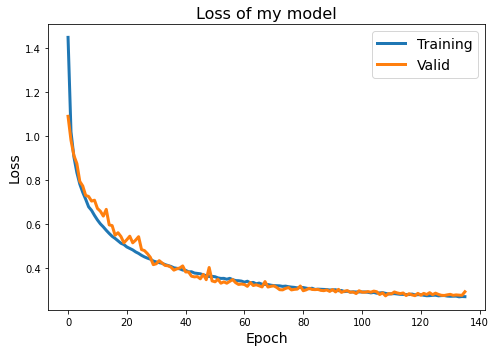

In [ ]:
plot_history_loss(history_4, title='Loss of my model')

We can see here that the training curve and the validation curve match perfectly. So there is no overfitting. What a perfection!

In [ ]:
evaluate_model('drive/My Drive/Colab Notebooks/dm2_models/best_model_4.h5')

Train_accuracy: 0.952, Test_accuracy: 0.932


We manage to have a good testing accuracy and a training accuracy close to the testing one (just 2%). So this is the best model so far.

## Predictions and Comments 👨‍🔬

In [ ]:
from prettytable import PrettyTable

In [ ]:
with tf.device('/device:GPU:0'):
    train_acc_dict = {}
    test_acc_dict = {}
    _, train_acc = model_teacher.evaluate(train_images, train_labels, verbose=0)
    _, test_acc = model_teacher.evaluate(test_images, test_labels, verbose=0)
    train_acc_dict["teacher_model"]= train_acc
    test_acc_dict["teacher_model"] = test_acc
    for i in range (1,5):
        saved_model = load_model('drive/My Drive/Colab Notebooks/dm2_models/best_model_'+str(i)+'.h5')
        _, train_acc = saved_model.evaluate(train_images, train_labels, verbose=0)
        _, test_acc = saved_model.evaluate(test_images, test_labels, verbose=0)
        train_acc_dict["model_"+str(i)]= train_acc
        test_acc_dict["model_"+str(i)] = test_acc

In [ ]:
t  = PrettyTable(["Model","Train_acc","Test_acc"])
for model in train_acc_dict:
    t.add_row([model,round(train_acc_dict[model],3),round(test_acc_dict[model],3)])
print(t)

+---------------+-----------+----------+
|     Model     | Train_acc | Test_acc |
+---------------+-----------+----------+
| teacher_model |    0.98   |   0.92   |
|    model_1    |   0.971   |   0.93   |
|    model_2    |   0.989   |  0.936   |
|    model_3    |   0.975   |  0.933   |
|    model_4    |   0.952   |  0.932   |
+---------------+-----------+----------+


We can see here that our models improved with all the parameters we added. The more knowledge we have, the better our model is.

Now, we are trying to predict the testing sample with our 4th model(the better one).

In [ ]:
#meilleur model : model 4
#prediction avec model 4

predicted = model_4.predict(test_images)

In [ ]:
predicted_labels = np.argmax(predicted,axis = 1)


In [ ]:
test_labels = np.argmax(test_labels,axis = 1)

We will show 30 first predictions. 

Print format : prediction(true label)

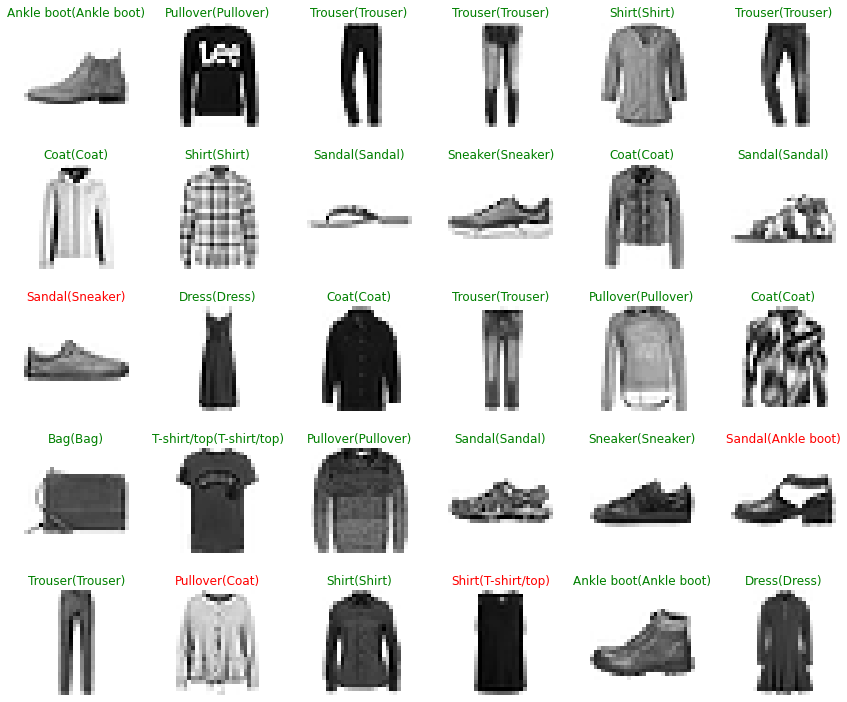

In [ ]:
#on va voir les 30 premières prédictions avec leurs vrai labels
n_rows = 5
n_cols = 6
plt.figure(figsize=(12, 10))
for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    if predicted_labels[i] == test_labels[i]:
      color = "green"
    else : color = "red"
    ax.set_title(label_dict[predicted_labels[i]]+"("+label_dict[test_labels[i]]+")", color = color)
    plt.imshow(test_images[i].reshape(28,28),interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

In [ ]:
incorrect_indexes = []
for i in range(len(test_labels)):
    if(not predicted_labels[i] == test_labels[i]):
        incorrect_indexes.append(i)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Distribution de labels mal prédits')

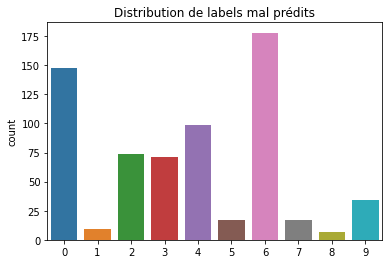

In [ ]:
import seaborn as sns
ax = sns.countplot(test_labels[incorrect_indexes])
ax.set_title("Distribution de labels mal prédits")

As we can see, the CNN have troubles to distinguish clothes with label 0, 2, 3, 4, 6, 9 which are T-shirt, Pullover, Dress, Coat, Shirt and Ankle boot.

In [ ]:
def show_bad_predictions(labels):
  n_rows = 5
  n_cols = 6
  plt.figure(figsize=(12, 10))
  j = 0
  for i in incorrect_indexes:
      if test_labels[i] == labels:
        if j >= 30 : break
        ax = plt.subplot(n_rows, n_cols, j+1)
        j+=1
        ax.set_title(label_dict[predicted_labels[i]]+"("+label_dict[test_labels[i]]+")", color = "red")
        plt.imshow(test_images[i].reshape(28,28),interpolation="none", cmap="gray_r")
        plt.axis("off")
  plt.tight_layout()

We will see that bad predictions made by our model are actually hard to predict, even with human eyes.

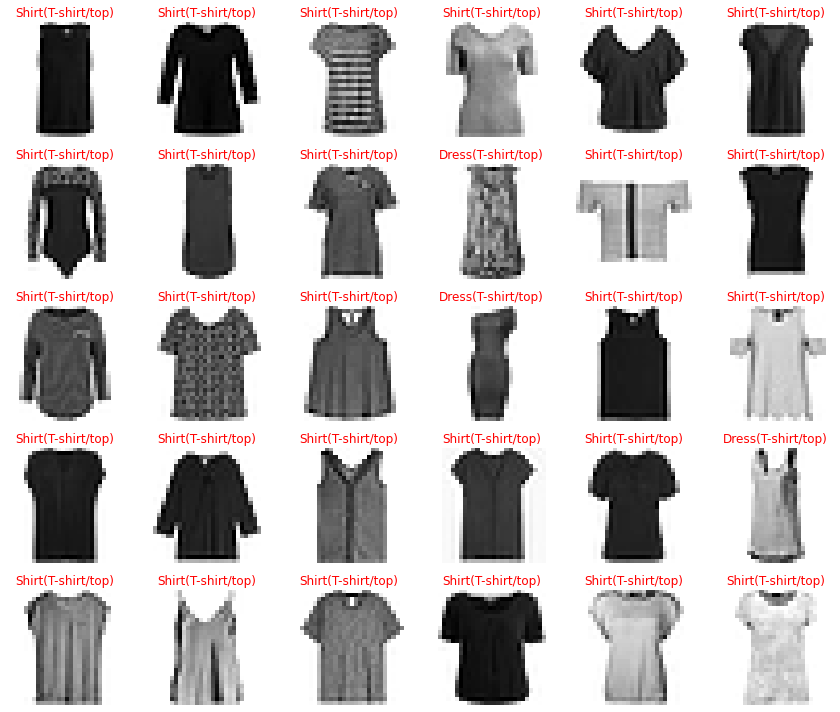

In [ ]:
show_bad_predictions(0)

Here the T-shirt is often mistaken with the Shirt. Even with human eyes, it is hard to say...

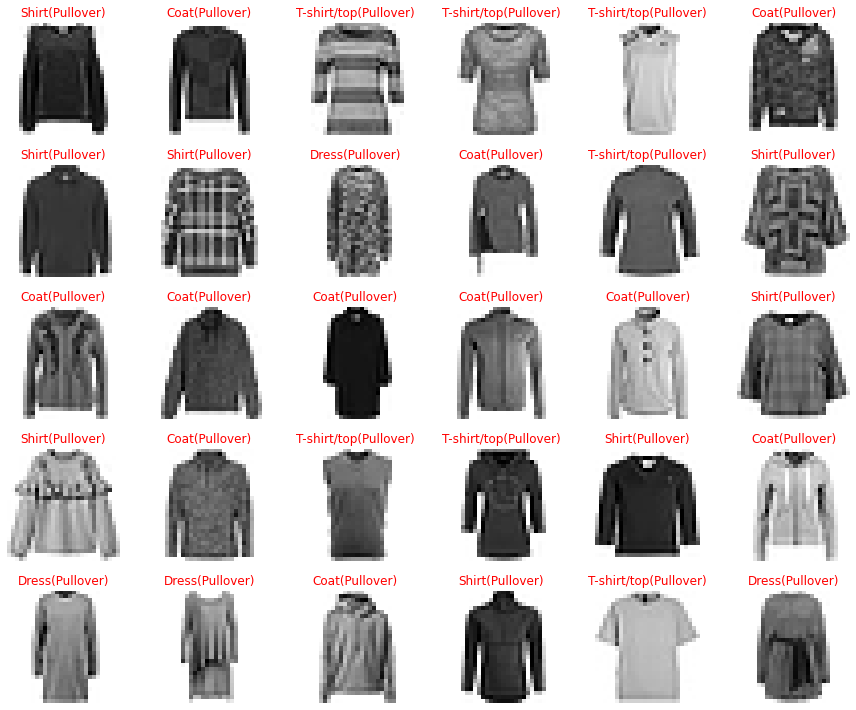

In [ ]:
show_bad_predictions(2)

Here pullover is often mistaken with dress, coat and t-shirt 

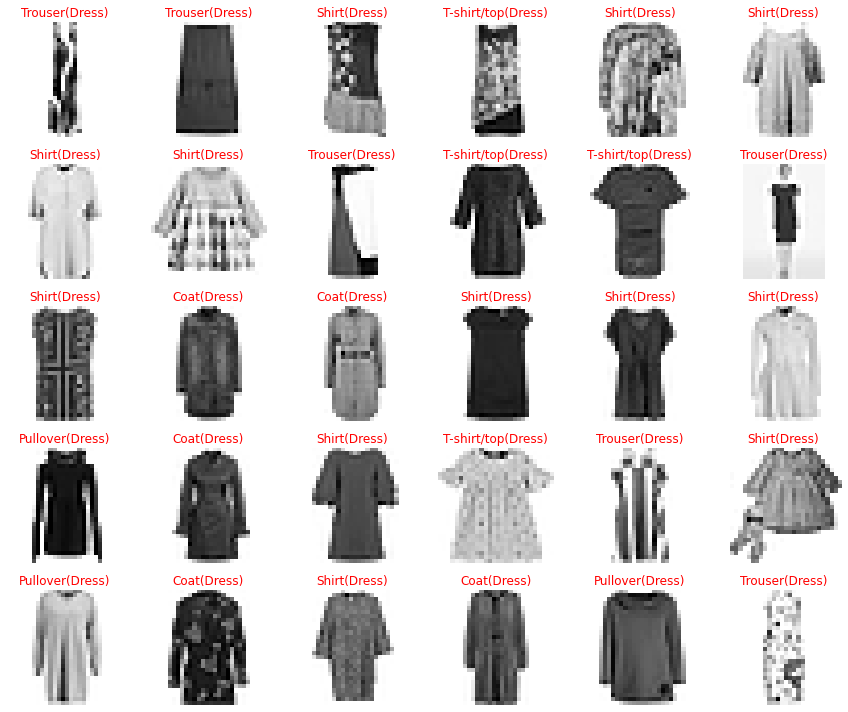

In [ ]:
show_bad_predictions(3)

Here dress is often mistaken with shirt, trouser and coat

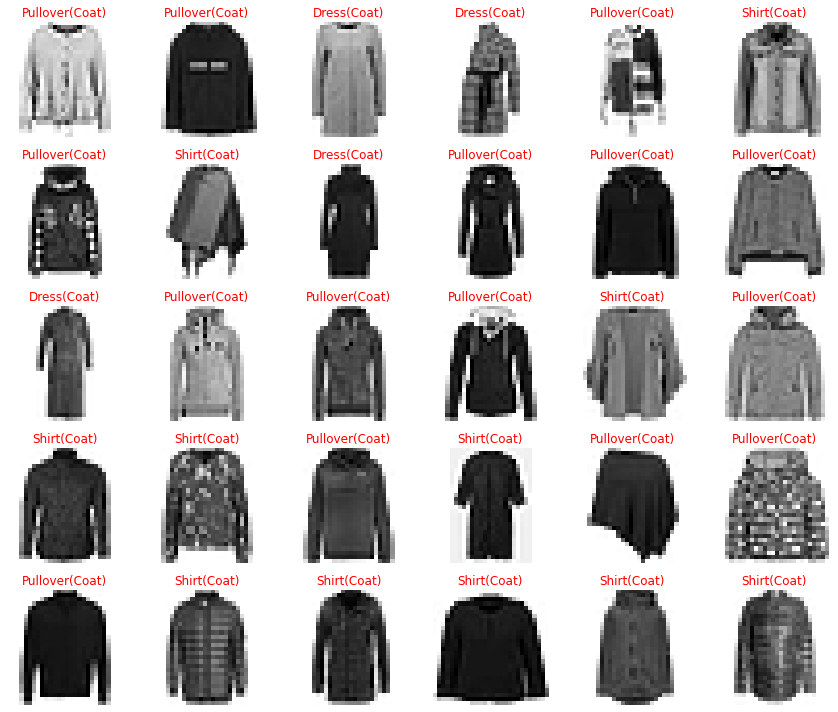

In [ ]:
show_bad_predictions(4)

Here coat is often mistaken with shirt, pullover and dress

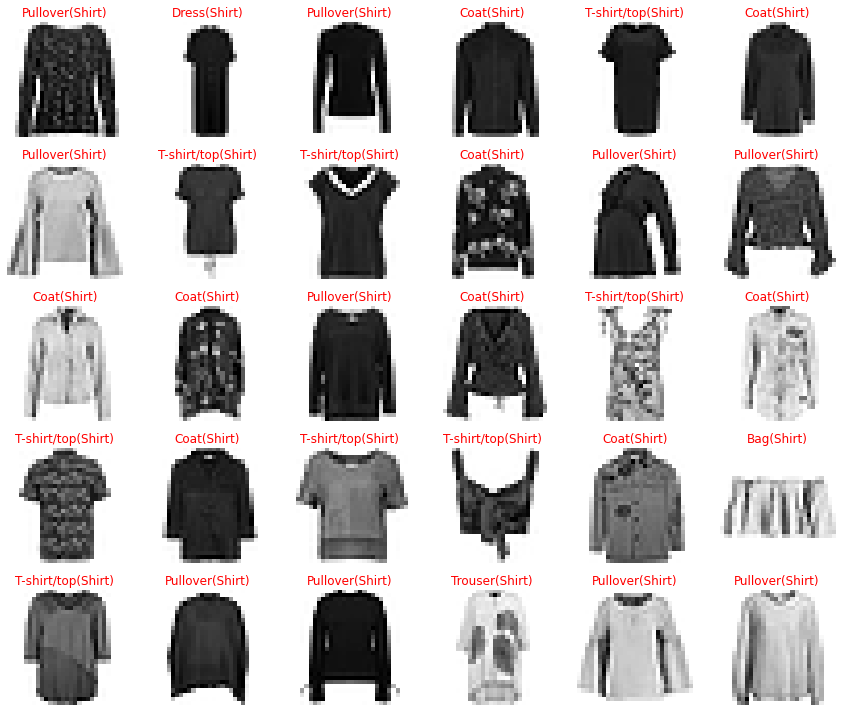

In [ ]:
show_bad_predictions(6)

Here shirt is often mistaken with pullover, coat and t-shirt 

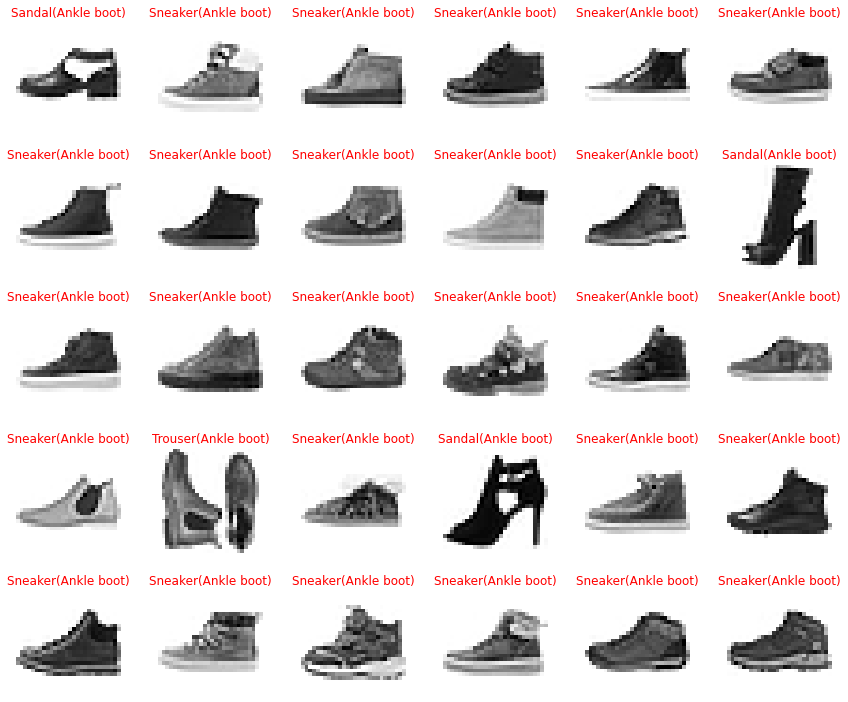

In [ ]:
show_bad_predictions(9)

Here ankle boot is often mistaken with sneaker and sandal.